In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import ModelCheckpoint


In [2]:
# important constants
batch_size = 128
epochs = 20
n_classes = 10
learning_rate = 0.1
width = 28
height = 28

In [3]:
fashion_labels = ["T-shirt/top","Trousers","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
#indices                0           1        2           3      4       5       6        7       8       9

In [4]:
# load the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# normalise the features  for better training
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# flatten the features  for use by the training algorithm
x_train = x_train.reshape((60000, width * height))
x_test = x_test.reshape((10000, width * height))

split = 50000
#split feature training  set into training and validation sets
(x_train, x_valid) = x_train[:split], x_train[split:]
(y_train, y_valid) = y_train[:split], y_train[split:]

# one-hot encode the labels using TensorFLow.
# then convert back to numpy as we cannot combine numpy
# and tensors as input to keras later
y_train_ohe = tf.one_hot(y_train, depth=n_classes).numpy()
y_valid_ohe = tf.one_hot(y_valid, depth=n_classes).numpy()
y_test_ohe = tf.one_hot(y_test, depth=n_classes).numpy()
#or use tf.keras.utils.to_categorical(y_train,10)

In [5]:
# show difference between original label and one-hot-encoded label
i=5
print(y_train[i]) # 'ordinairy' number value of label at index i
print (tf.one_hot(y_train[i], depth=n_classes))# same value as a 1. in correct position in an length 10 1D tensor
print(y_train_ohe[i]) # same value as a 1. in correct position in an length 10 1D numpy array

2
tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


Ankle bootT-shirt/topT-shirt/topDressT-shirt/topPulloverSneakerPulloverSandalSandal

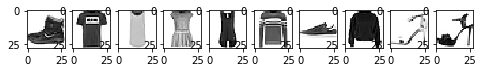

In [6]:
# print sample fashion images.
# we have to reshape the image held in x_train back to width by height
# as we flattened it for training into width*height
import matplotlib.pyplot as plt
%matplotlib inline
_,image  = plt.subplots(1,10,figsize=(8,1))

for i in range(10):
    image[i].imshow(np.reshape(x_train[i],(width, height)), cmap="Greys")
    print(fashion_labels[y_train[i]],sep='', end='')

In [7]:
# model definition (one canonical Google way)
class LogisticRegression(tf.keras.Model):

    def __init__(self, num_classes):
        super(LogisticRegression, self).__init__() # call the constructor of the parent class (Model)
        self.dense = tf.keras.layers.Dense(num_classes) #create an empty  layer called dense with 10 elements.

    def call(self, inputs, training=None, mask=None): # required for our forward pass
        output = self.dense(inputs) # copy training inputs into our layer

        # softmax op does not exist on the gpu, so force execution on the CPU
        with tf.device('/cpu:0'):
            output = tf.nn.softmax(output) # softmax is near one for maximum value in output
                                           # and near zero for the other values.

        return output

In [8]:
# build the model
model = LogisticRegression(n_classes)
# compile the model
#optimiser = tf.train.GradientDescentOptimizer(learning_rate)
optimiser =tf.keras.optimizers.Adam() #not supported in eager execution mode.
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'], )

# TF Keras tries to use the entire dataset to determine the shape without this step when using .fit()
# So, use one sample of the provided input dataset size to determine input/output shapes for the model
dummy_x = tf.zeros((1, width * height))
model.call(dummy_x)


checkpointer = ModelCheckpoint(filepath="./model.weights.best.hdf5", verbose=2, save_best_only=True, save_weights_only=True)
    # train the model
model.fit(x_train, y_train_ohe, batch_size=batch_size, epochs=epochs,
              validation_data=(x_valid, y_valid_ohe), callbacks=[checkpointer], verbose=2)
    #load model with the best validation accuracy
model.load_weights("./model.weights.best.hdf5")

    # evaluate the model on the test set
scores = model.evaluate(x_test, y_test_ohe, batch_size, verbose=2)
print("Final test loss and accuracy :", scores)
y_predictions = model.predict(x_test)


Train on 50000 samples, validate on 10000 samples
Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.56849, saving model to ./model.weights.best.hdf5
50000/50000 - 1s - loss: 0.7709 - accuracy: 0.7504 - val_loss: 0.5685 - val_accuracy: 0.8088
Epoch 2/20

Epoch 00002: val_loss improved from 0.56849 to 0.51089, saving model to ./model.weights.best.hdf5
50000/50000 - 1s - loss: 0.5298 - accuracy: 0.8248 - val_loss: 0.5109 - val_accuracy: 0.8300
Epoch 3/20

Epoch 00003: val_loss improved from 0.51089 to 0.47657, saving model to ./model.weights.best.hdf5
50000/50000 - 1s - loss: 0.4844 - accuracy: 0.8385 - val_loss: 0.4766 - val_accuracy: 0.8357
Epoch 4/20

Epoch 00004: val_loss improved from 0.47657 to 0.46521, saving model to ./model.weights.best.hdf5
50000/50000 - 1s - loss: 0.4616 - accuracy: 0.8439 - val_loss: 0.4652 - val_accuracy: 0.8404
Epoch 5/20

Epoch 00005: val_loss improved from 0.46521 to 0.45195, saving model to ./model.weights.best.hdf5
50000/50000 - 1s - loss: 0.4451 

When prediction is  3
ie. predicted label is Dress
True label is  Dress


Predicted V (True) fashion labels, green is correct, red is wrong


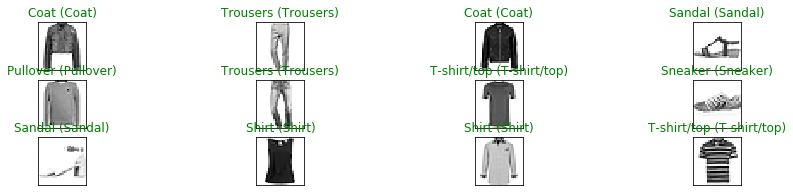

In [9]:
    # example of one predicted versus one true fashion label
index = 42
index_predicted = np.argmax(y_predictions[index]) # largest label probability
index_true = np.argmax(y_test_ohe[index]) # pick out index of element with a 1 in it
print("When prediction is ",index_predicted)
print("ie. predicted label is", fashion_labels[index_predicted])
print("True label is ",fashion_labels[index_true])


print ("\n\nPredicted V (True) fashion labels, green is correct, red is wrong")
size = 12 # i.e. 12 random numbers chosen out of x_test.shape[0] =1000, we do not replace them
fig = plt.figure(figsize=(15,3))
rows = 3
cols = 4

for i, index in enumerate(np.random.choice(x_test.shape[0], size = size, replace = False)):
          axis = fig.add_subplot(rows,cols,i+1, xticks=[], yticks=[]) # position i+1 in grid with rows rows and cols columns
          axis.imshow(x_test[index].reshape(width,height), cmap="Greys")
          index_predicted = np.argmax(y_predictions[index])
          index_true = np.argmax(y_test_ohe[index])
          axis.set_title(("{} ({})").format(fashion_labels[index_predicted],fashion_labels[index_true]),
                                                  color=("green" if index_predicted==index_true else "red"))
